# Карта метода


KNeighborsClassifier - это алгоритм классификации, который относится к семейству методов "ближайших соседей" (k-nearest neighbors, k-NN). Этот алгоритм основан на идее, что объекты в пространстве признаков, близкие друг к другу, имеют похожие метки классов.

Основная идея метода заключается в том, чтобы классифицировать новый объект путем анализа меток классов k его ближайших соседей. Классификация осуществляется путем голосования: метка класса нового объекта определяется путем подсчета числа соседей в каждом классе и выбора класса, который наиболее часто встречается среди k ближайших соседей.

Основные параметры KNeighborsClassifier:
* n_neighbors: Число ближайших соседей, которые используются для классификации нового объекта.
* weights: Веса, присваиваемые ближайшим соседям. Возможные значения: "uniform" (все соседи имеют одинаковый вес) или "distance" (вес каждого соседа обратно пропорционален его расстоянию до нового объекта).
* metric: Метрика расстояния, используемая для определения близости объектов. Например, евклидово расстояние или манхэттенское расстояние.
algorithm: Алгоритм, используемый для поиска ближайших соседей. Возможные значения: "auto", "ball_tree", "kd_tree" или "brute".
* p: Параметр метрики расстояния (например, для метрики Минковского).
* leaf_size: Размер листа (используется для построения деревьев).

Хорошо работает на небольших наборах данных и не требует обучения в явном виде, что делает его привлекательным для простых задач. Однако он может быть вычислительно затратным на больших наборах данных из-за необходимости хранения всех объектов обучающей выборки.


*Кластеризация — объединение похожих объектов в группы или кластеры. Кластеризацию также называют кластерным анализом или сегментацией.  
*Oбучение без учителя — задача машинного обучения без целевого признака, когда взаимосвязи между объектами алгоритмы находят самостоятельно.

# Реализация

## Импорт библиотек

In [1]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [2]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)

## Чтение данных

In [3]:
df = pd.read_excel('../data/dataset.xlsx')
dataset = df.copy()

## Предобработка

In [4]:
categorial_features = dataset.select_dtypes(include=['object']).columns
numerical_features = dataset.select_dtypes(include=['int64', 'float64']).columns

In [5]:
dataset[categorial_features] = pd.get_dummies(dataset[categorial_features], drop_first=True)

X = dataset.drop(['Больной'], axis=1)
y = dataset['Больной']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.33,
                                                    random_state=SEED,
                                                    stratify=y,
                                                    shuffle=True)

In [6]:
scaler = StandardScaler()

X_std = X.copy()
X_train_std = X_train.copy()
X_test_std = X_test.copy()

scaler.fit(X_train[numerical_features])

X_train_std[numerical_features] = scaler.transform(X_train[numerical_features])
X_test_std[numerical_features] = scaler.transform(X_test[numerical_features])
X_std[numerical_features] = scaler.transform(X[numerical_features])

## Поиск лучших гиперпараметров для модели

In [7]:
knn = KNeighborsClassifier()
parameters = {'n_neighbors':[3, 6, 10, 20],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}
clf = GridSearchCV(knn, parameters)
clf.fit(X_std, y)
print('Best params: ', clf.best_params_)
print('Best train acc score: ', clf.best_score_)

Best params:  {'n_neighbors': 6, 'p': 1, 'weights': 'uniform'}
Best train acc score:  0.9108695652173914


## Обучение лучшей модели

In [9]:
knn = KNeighborsClassifier(**clf.best_params_)
knn.fit(X_train_std, y_train)

KNeighborsClassifier(n_neighbors=6, p=1)

## Метрики для модели

Best val acc score:  0.881578947368421


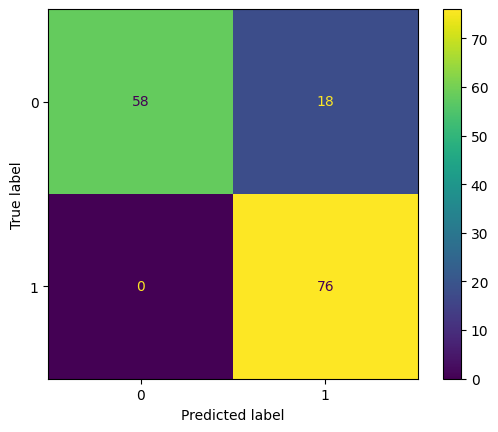

In [11]:
y_pred = knn.predict(X_test_std)

acc = accuracy_score(y_test, y_pred)
print('Best val acc score: ', acc)
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot();

# Интерпретация

In [14]:
shap.initjs()

explainer = shap.KernelExplainer(knn.predict_proba, X_test)

Using 152 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Explain a single prediction from the test set

In [12]:
sample_inter = 0
sample_test = 0

shap_values = explainer.shap_values(X_test.iloc[sample_inter, :])
shap.force_plot(explainer.expected_value[0], shap_values[:, 0], X_test.iloc[0, :])

## Explain all the predictions in the test set

In [37]:
shap_values = explainer.shap_values(X_test)
shap.force_plot(explainer.expected_value[0], shap_values[..., 0], X_test)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 152/152 [05:23<00:00,  2.13s/it]


## Waterfall

  0%|          | 0/10 [00:00<?, ?it/s]

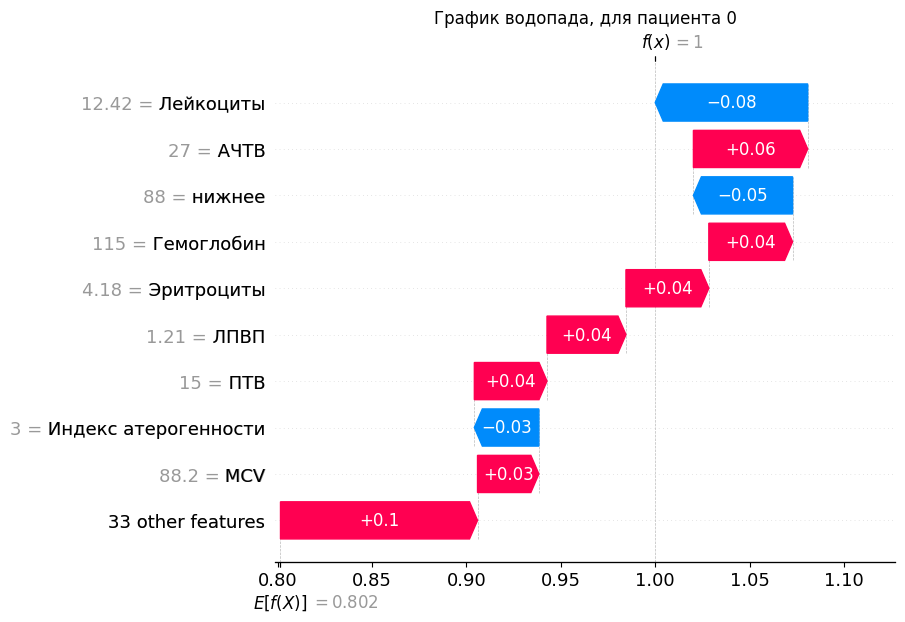

In [31]:
shap_values = explainer(X_std.iloc[:10, :])
shap_values.data = X_test.iloc[:10, :]
id_to_explain = 0
output_to_explain = 1

shap.plots.waterfall(shap_values[id_to_explain,:,output_to_explain], show=False)
plt.title(f'График водопада, для пациента {id_to_explain}')
plt.show()

## Partial dependence plots

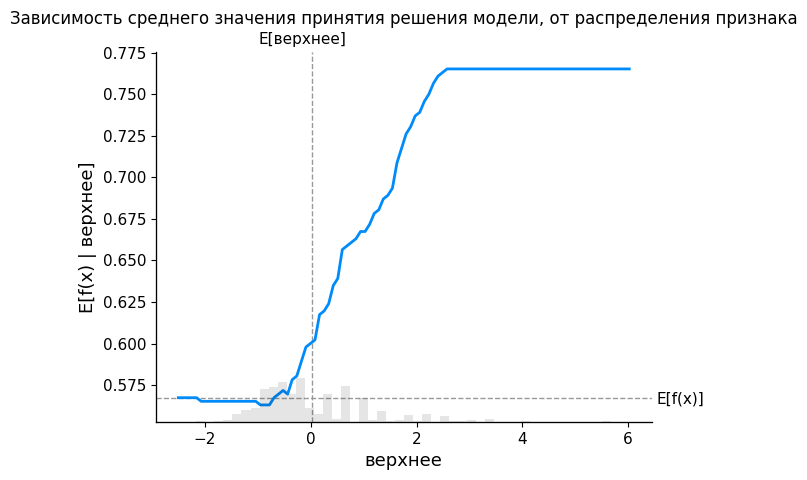

In [27]:
feature = 'верхнее'

shap.partial_dependence_plot(
    feature,
    knn.predict,
    X_std,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
    show=False
)
plt.title('Зависимость среднего значения принятия решения модели, от распределения признака')
plt.show();

## Beeswarm -график важности признаков

  0%|          | 0/20 [00:00<?, ?it/s]

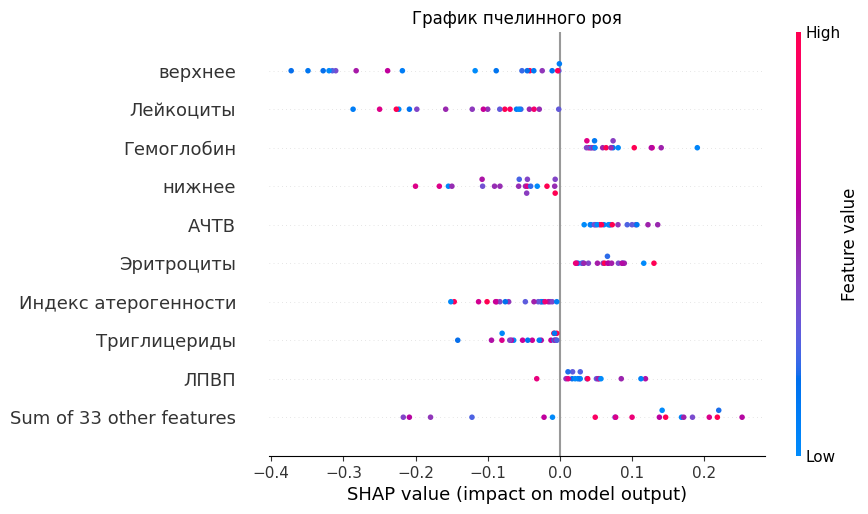

In [32]:
num_points = 20

shap_values = explainer(X_std.iloc[:num_points, :])
shap_values.data = X_test.iloc[:num_points, :]

shap.plots.beeswarm(shap_values[:, :, 1], show=False)
plt.title('График пчелинного роя')
plt.show();

Высокие значения давления, MCV, артериальной гипертензии, лейкоцитов предшествуют целевому заболеваянию. Низкое ЛПВП, гемоглобина, фибриляций предсердий, отчасти гематокрит также способствуют повышению предсказания таргета.

* значения слева от центральной вертикальной линии — это negative класс (0), справа — positive (1)
* чем толще линия на графике, тем больше таких точек наблюдения
* чем краснее точки на графике, тем выше значения фичи в ней

## Bar chart

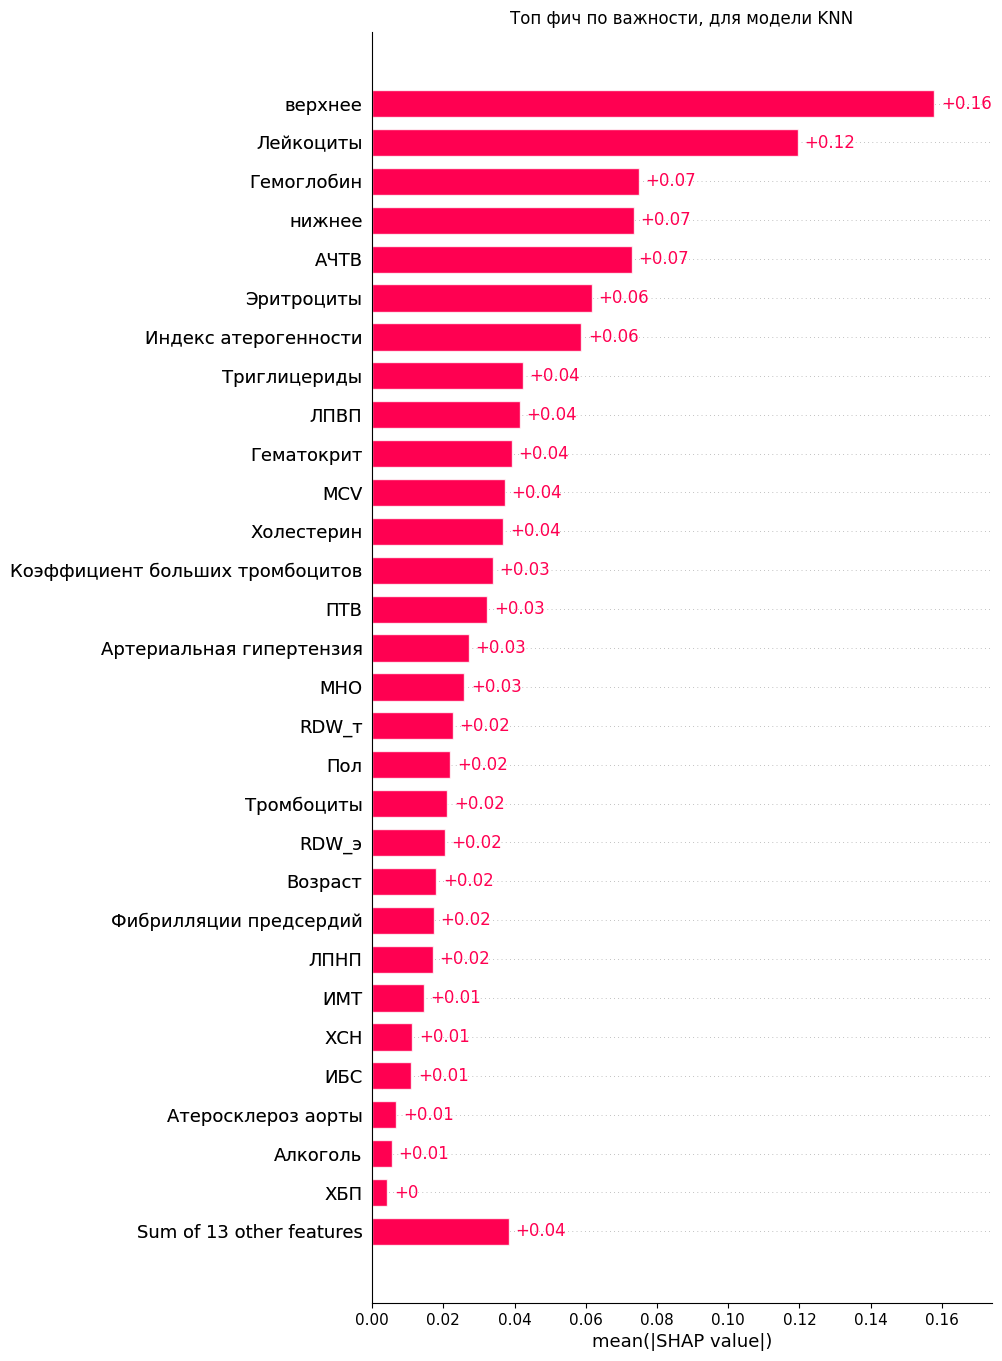

In [40]:
shap.plots.bar(shap_values[:, :, 1], max_display=30, show=False)
plt.title('Топ фич по важности, для модели KNN')
plt.show();

## Heatmap

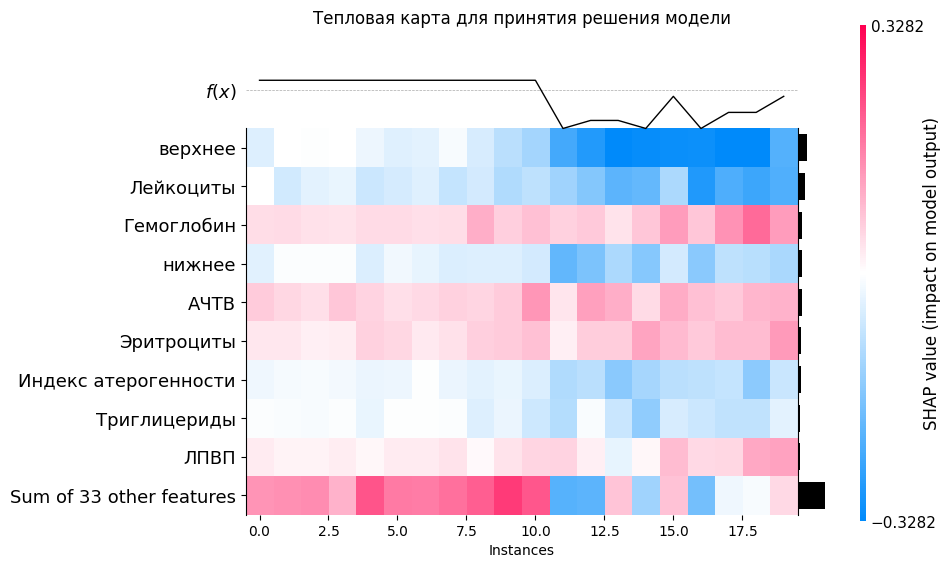

In [38]:
shap.plots.heatmap(shap_values[:, :, 1], show=False)
plt.title('Тепловая карта для принятия решения модели')
plt.show()

## SHAP value

  0%|          | 0/20 [00:00<?, ?it/s]

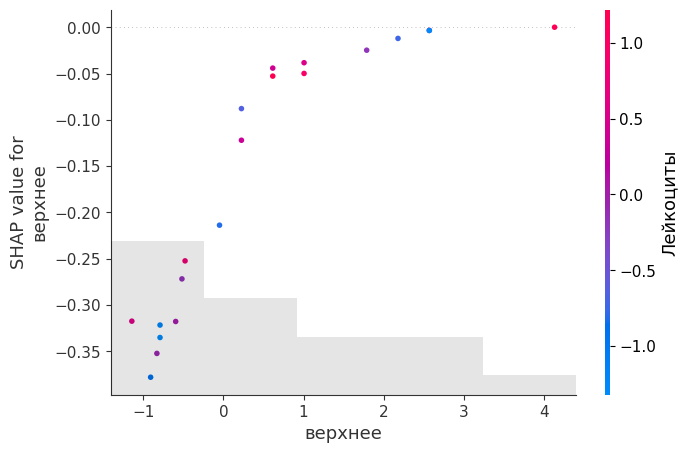

In [46]:
feature = "верхнее"
num_points = 20

shap_values = explainer(X_std.iloc[:num_points, :])
shap.plots.scatter(shap_values[:, feature, 1], color=shap_values[:, :, 0])